In [18]:

import matplotlib.pyplot as plt
import nibabel as nib
import math

import numpy as np
import os 

from scipy.fft import fft2, fftshift, ifftshift, ifft2
#from PIL import Image
import torch
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from pytorch_msssim import SSIM

(180, 128, 128)
Mean: 0.17802765582580674
le min et le max 0.0 -1.0000000488216667
[0.03584016 0.03584016 0.03584016 0.03584016 0.03584016 0.03584016
 0.03584016 0.03584016 0.03584016 0.03584016 0.03584016 0.03584016
 0.03584016 0.03584016 0.03584016 0.03584017 0.03584015 0.03584022
 0.03584001 0.03584054 0.03583945 0.0358405  0.03584696 0.03586475
 0.03659576 0.03695948 0.03588179 0.03853408 0.04142947 0.04392689
 0.04354457 0.07132583 0.36013459 0.89552484 0.60046768 0.67531047
 0.59738785 0.22936108 0.14301209 0.28405448 0.32097304 0.16956852
 0.18694178 0.27663555 0.21276687 0.20352712 0.33401924 0.41798755
 0.42432036 0.41068753 0.32089823 0.26932268 0.42743473 0.47943424
 0.41103889 0.39705974 0.37485155 0.33381331 0.3193168  0.41960594
 0.50401549 0.42459565 0.35640369 0.35620433 0.35338629 0.21192779
 0.28119271 0.23729778 0.28693339 0.36927275 0.38385895 0.43152961
 0.44787092 0.50952875 0.52319352 0.45481362 0.43582138 0.425288
 0.42372437 0.44458569 0.43033132 0.38769824 0.3

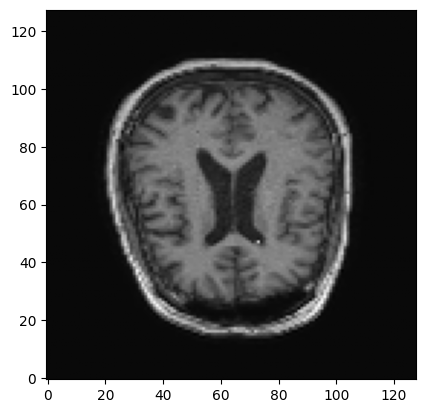

In [21]:
indices_base =[71, 94, 84, 116, 61, 31, 52, 16, 35, 95] # (Masque différent)
path_folder = os.getcwd()
import os
import numpy as np
from PIL import Image
data_base = np.load("images_brain_128.npy")
bigy=data_base
#bigy=data_base[indices_base]
print(bigy.shape)
print("Mean:", bigy.mean().item())
print(f"le min et le max {bigy.min()} -{bigy.max()}")

print(bigy[4,32,:],)
# Affichage d’une image
plt.imshow(bigy[4,:,:], cmap="gray", origin="lower")
plt.show()

In [20]:
data_base0 = np.load("images_brain_128.npy")
bigy0=data_base0
#bigy=data_base[indices_base]

print(bigy0.shape)
print("Mean:", bigy0.mean().item())
print(f"le min et le max {bigy0.min()} -{bigy0.max()}")

(180, 128, 128)
Mean: 0.17802765582580674
le min et le max 0.0 -1.0000000488216667


In [4]:
# n_images=180
# cols = 10  # tu peux ajuster
# rows = math.ceil(n_images / cols)

# # Taille de la figure (ajuster selon ton écran)
# fig, axs = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))

# # Affichage de chaque image
# for i in range(rows * cols):
#     if i < n_images:
#         axs[i // cols, i % cols].imshow(bigy[i,:,:], cmap='gray', origin='lower')
#     axs[i // cols, i % cols].axis('off')

# plt.tight_layout()
# plt.show()

In [22]:
writer=SummaryWriter()
#tensorboard --logdir=runs
# Lancer tensorboard

class DoubleConv(nn.Module):
    """Bloc de 2 convolutions: (Conv => ReLU => Conv => ReLU)"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )   

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encodeur
        self.enc1 = DoubleConv(in_channels, 32) # 64/64
        self.pool1 = nn.MaxPool2d(2)            # 32/32
        self.enc2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)            # 16/16

        # Bottleneck
        self.bottleneck = DoubleConv(64, 128)   # 16/16

        # Decodeur
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2) # 32/32
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2) # 64/64
        self.dec1 = DoubleConv(64, 32)

        # Sortie
        self.output = nn.Conv2d(32, out_channels, kernel_size=1)
        self.activation = nn.Sigmoid()  # <--- AJOUTÉ

    def forward(self, x):
        #print(f"dimension de {x.shape}")
        # Encode
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool1(x1))
        x3 = self.bottleneck(self.pool2(x2))

        # Decode
        x = self.up2(x3)
        x = self.dec2(torch.cat([x, x2], dim=1))  # concat skip, ca permet de récupérer les détails perdus.
        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))  # concat skip

        x = self.output(x)
        x = self.activation(x)  # <--- AJOUTÉ
        return x


In [6]:
# Fine tuning
'''
def FourierTransformMask0(data, rotation=10):
    # Si data est un Subset ou Dataset, on extrait les données
    if isinstance(data, (torch.utils.data.Subset, torch.utils.data.Dataset)):
        data_list = [data[i] for i in range(len(data))]
        data_tensor = torch.stack(data_list)
    elif isinstance(data, torch.Tensor):
        data_tensor = data
    else:
        raise TypeError(f"Type non supporté : {type(data)}")

    # Conversion vers NumPy pour le traitement FFT
    data_numpy = data_tensor.cpu().numpy()  # (N, C, H, W) ou (N, H, W)

    
    F_masked_with_images_spatial=[]

    for image in data_numpy:
        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)
        if image.ndim == 3:
            image = image.squeeze()

        FT1 = fft2(image)
        #total_energy = np.sum(np.abs(FT1))
        #FT1 = FT1 / (total_energy + 1e-8)

        F_shifted = fftshift(FT1)
        rows, cols = F_shifted.shape
        crow, ccol = rows // 2, cols // 2

        mask = np.zeros((rows, cols), dtype=np.float32)
        for angle_deg in np.arange(0, 180, rotation):
            angle_rad = np.deg2rad(angle_deg)
            dx = np.cos(angle_rad)
            dy = np.sin(angle_rad)

            for r in range(-max(rows, cols), max(rows, cols)):
                x = int(crow + r * dx)
                y = int(ccol + r * dy)
                if 0 <= x < rows and 0 <= y < cols:
                    mask[x, y] = 1
        mask1 = np.zeros((rows, cols), dtype=np.float32)
        for x in range(0,rows,1):
            if (crow - 5 < x < crow + 5):
                mask1[x, :] = 1
            elif (crow - 13 < x < crow - 10):
                mask1[x, :] = 1
            elif (crow + 10 < x < crow + 13):
                mask1[x, :] = 1    
            elif (crow + 20 < x < crow + 22):
                mask1[x, :] = 1    
            elif (crow - 23 < x < crow - 20):
                mask1[x, :] = 1
            # if (crow - 7 < x < crow + 7):
            #     mask1[x, :] = 1
            # elif (crow - 15 < x < crow - 10):
            #     mask1[x, :] = 1
            # elif (crow + 10 < x < crow + 15):
            #     mask1[x, :] = 1    
            # elif (crow + 20 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 20):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 33):
            #     mask1[x, :] = 1    
            # elif (crow - 33 < x < crow - 30):
            #     mask1[x, :] = 1
            # if (crow - 15 < x < crow + 15):
            #     mask1[x, :] = 1   
            # elif (crow + 18 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 18):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 35):
            #     mask1[x, :] = 1    
            # elif (crow - 35 < x < crow - 30):
            #     mask1[x, :] = 1
            # elif (crow + 40 < x < crow + 45):
            #     mask1[x, :] = 1    
            # elif (crow - 45 < x < crow - 40):
            #     mask1[x, :] = 1


        F_masked_shifted = F_shifted * mask1
        F_masked_spatial=np.abs(ifft2(ifftshift(F_masked_shifted)))
        F_masked_with_images_spatial.append(F_masked_spatial)
    

    F_tensor_masked_shifted = torch.tensor(np.stack(F_masked_with_images_spatial), dtype=torch.float32)  # (N, H, W, 1)
    F_tensor_masked_shifted=F_tensor_masked_shifted.unsqueeze(1)
    #data_tensor=data_tensor.permute(0,3,1,2) # (N, 1, H, W)
    

    return TensorDataset(F_tensor_masked_shifted, data_tensor)
    #return TensorDataset(data_tensor, F_tensor)
'''

'\ndef FourierTransformMask0(data, rotation=10):\n    # Si data est un Subset ou Dataset, on extrait les données\n    if isinstance(data, (torch.utils.data.Subset, torch.utils.data.Dataset)):\n        data_list = [data[i] for i in range(len(data))]\n        data_tensor = torch.stack(data_list)\n    elif isinstance(data, torch.Tensor):\n        data_tensor = data\n    else:\n        raise TypeError(f"Type non supporté : {type(data)}")\n\n    # Conversion vers NumPy pour le traitement FFT\n    data_numpy = data_tensor.cpu().numpy()  # (N, C, H, W) ou (N, H, W)\n\n    \n    F_masked_with_images_spatial=[]\n\n    for image in data_numpy:\n        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)\n        if image.ndim == 3:\n            image = image.squeeze()\n\n        FT1 = fft2(image)\n        #total_energy = np.sum(np.abs(FT1))\n        #FT1 = FT1 / (total_energy + 1e-8)\n\n        F_shifted = fftshift(FT1)\n        rows, cols = F_shifted.shape\n        crow, ccol = rows // 2, 

In [23]:

def FourierTransformMask(data, rotation=12):
    # Si data est un Subset ou Dataset, on extrait les données
    if isinstance(data, (torch.utils.data.Subset, torch.utils.data.Dataset)):
        data_list = [data[i] for i in range(len(data))]
        data_tensor = torch.stack(data_list)
    elif isinstance(data, torch.Tensor):
        data_tensor = data
    else:
        raise TypeError(f"Type non supporté : {type(data)}")

    # Conversion vers NumPy pour le traitement FFT
    data_numpy = data_tensor.cpu().numpy()  # (N, C, H, W) ou (N, H, W)

    
    F_masked_with_images_spatial=[]

    for image in data_numpy:
        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)
        if image.ndim == 3:
            image = image.squeeze()

        FT1 = fft2(image)
        #total_energy = np.sum(np.abs(FT1))
        #FT1 = FT1 / (total_energy + 1e-8)

        F_shifted = fftshift(FT1)
        rows, cols = F_shifted.shape
        crow, ccol = rows // 2, cols // 2

        mask = np.zeros((rows, cols), dtype=np.float32)
        for angle_deg in np.arange(0, 180, rotation):
            angle_rad = np.deg2rad(angle_deg)
            dx = np.cos(angle_rad)
            dy = np.sin(angle_rad)

            for r in range(-max(rows, cols), max(rows, cols)):
                x = int(crow + r * dx)
                y = int(ccol + r * dy)
                if 0 <= x < rows and 0 <= y < cols:
                    mask[x, y] = 1
        mask1 = np.zeros((rows, cols), dtype=np.float32)
        for x in range(0,rows,1):
            if (crow - 5 < x < crow + 5):
                mask1[x, :] = 1
            elif (crow - 13 < x < crow - 10):
                mask1[x, :] = 1
            elif (crow + 10 < x < crow + 13):
                mask1[x, :] = 1    
            elif (crow + 20 < x < crow + 22):
                mask1[x, :] = 1    
            elif (crow - 23 < x < crow - 20):
                mask1[x, :] = 1
            # if (crow - 7 < x < crow + 7):
            #     mask1[x, :] = 1
            # elif (crow - 15 < x < crow - 10):
            #     mask1[x, :] = 1
            # elif (crow + 10 < x < crow + 15):
            #     mask1[x, :] = 1    
            # elif (crow + 20 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 20):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 33):
            #     mask1[x, :] = 1    
            # elif (crow - 33 < x < crow - 30):
            #     mask1[x, :] = 1
            # if (crow - 15 < x < crow + 15):
            #     mask1[x, :] = 1   
            # elif (crow + 18 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 18):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 35):
            #     mask1[x, :] = 1    
            # elif (crow - 35 < x < crow - 30):
            #     mask1[x, :] = 1
            # elif (crow + 40 < x < crow + 45):
            #     mask1[x, :] = 1    
            # elif (crow - 45 < x < crow - 40):
            #     mask1[x, :] = 1


        F_masked_shifted = F_shifted * mask
        F_masked_spatial=np.abs(ifft2(ifftshift(F_masked_shifted)))
        F_masked_with_images_spatial.append(F_masked_spatial)
    

    F_tensor_masked_shifted = torch.tensor(np.stack(F_masked_with_images_spatial), dtype=torch.float32)  # (N, H, W, 1)
    F_tensor_masked_shifted=F_tensor_masked_shifted.unsqueeze(1)
    #data_tensor=data_tensor.permute(0,3,1,2) # (N, 1, H, W)
    

    return TensorDataset(F_tensor_masked_shifted, data_tensor)
    #return TensorDataset(data_tensor, F_tensor)


In [8]:
# Fine Tuning
'''# Dataset personnalisé
class NoisyImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.clean_images = clean_images
        self.transform = transform

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean = self.clean_images[idx]# Pour une image
        
        if self.transform:
            clean = self.transform(clean)

        return clean  # entrée = bruitée, cible = propre

# Transfo pour passer en tenseur [0,1]
transform = transforms.Compose([
    transforms.ToTensor(), #Pas nombre à virgule
])

# Création du Dataset
train_dataset0 = NoisyImageDataset(bigy0, transform=transform)
batch_size = 16



dataset_size = len(train_dataset0)
# Calcul des tailles
train_size0 = int(0.8* dataset_size)
val_size0 = int(0.5*(dataset_size - train_size0))
test_size0 = dataset_size - train_size0 - val_size0  # Le reste

# k=[1,2,3,4,5]
# dict_seed= {}

# for i in k:
#     seed=i
seed=1
torch.manual_seed(seed) 
generator = torch.Generator().manual_seed(seed)
# Split direct en 3 parties
train_dataset_split0, validation_dataset_split0, test_dataset_split0 = random_split(
train_dataset0,
[train_size0, val_size0, test_size0],
generator=generator
)

train_indices = train_dataset_split0.indices
val_indices = validation_dataset_split0.indices
test_indices = test_dataset_split0.indices  

train_dataset_split_mask0=FourierTransformMask0(train_dataset_split0,rotation=12)
validation_dataset_split_mask0=FourierTransformMask0(validation_dataset_split0,rotation=12)
test_dataset_split_mask0=FourierTransformMask0(test_dataset_split0,rotation=12)

# Création des DataLoaders 
train_loader0 = DataLoader(train_dataset_split_mask0, batch_size=batch_size, shuffle=True) # shuffle=True permet que à chaque epoch se soit pas le meme groupe de 16 images qui est pris ensemble
validation_loader0 = DataLoader(validation_dataset_split_mask0, batch_size=batch_size, shuffle=False)
test_loader0 = DataLoader(test_dataset_split_mask0, batch_size=batch_size, shuffle=False)

# if seed==1 or seed==2:
print("seed",seed)

print(f"Nombre d'images d'entraînement : {len(train_dataset_split0)}")
print(train_dataset_split0.indices)
print(f"Nombre d'images de validation : {len(validation_dataset_split0)}")
print(validation_dataset_split0.indices)
print(f"Nombre d'images de test : {len(test_dataset_split0)}")
print(test_dataset_split0.indices)

for F_tensor_masked_shifted0, data_tensor0 in train_loader0:
    print(f"Plage des valeurs des images d'entrée (bruitées) : {F_tensor_masked_shifted0.min().item()} - {F_tensor_masked_shifted0.max().item()}")
    print(f"Plage des valeurs des images cibles (propres) : {data_tensor0.min().item()} - {data_tensor0.max().item()}")

    print(f"bruitées {F_tensor_masked_shifted0.shape}")
    print(f"image_base {data_tensor0.shape}")
    break

    # dict_seed[seed] = {
    #     "train": train_loader,
    #     "validation" : validation_loader,
    #     "test": test_loader,
    #     "indices":{
    #         "train": train_indices,
    #         "validation" : val_indices,
    #         "test": test_indices

    #     }
    # }
'''

'# Dataset personnalisé\nclass NoisyImageDataset(Dataset):\n    def __init__(self, clean_images, transform=None):\n        self.clean_images = clean_images\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.clean_images)\n\n    def __getitem__(self, idx):\n        clean = self.clean_images[idx]# Pour une image\n        \n        if self.transform:\n            clean = self.transform(clean)\n\n        return clean  # entrée = bruitée, cible = propre\n\n# Transfo pour passer en tenseur [0,1]\ntransform = transforms.Compose([\n    transforms.ToTensor(), #Pas nombre à virgule\n])\n\n# Création du Dataset\ntrain_dataset0 = NoisyImageDataset(bigy0, transform=transform)\nbatch_size = 16\n\n\n\ndataset_size = len(train_dataset0)\n# Calcul des tailles\ntrain_size0 = int(0.8* dataset_size)\nval_size0 = int(0.5*(dataset_size - train_size0))\ntest_size0 = dataset_size - train_size0 - val_size0  # Le reste\n\n# k=[1,2,3,4,5]\n# dict_seed= {}\n\n# for i in k:\n#  

In [24]:

# Dataset personnalisé
class NoisyImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.clean_images = clean_images
        self.transform = transform

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean = self.clean_images[idx]# Pour une image
        
        if self.transform:
            clean = self.transform(clean)

        return clean  # entrée = bruitée, cible = propre

# Transfo pour passer en tenseur [0,1]
transform = transforms.Compose([
    transforms.ToTensor(), #Pas nombre à virgule
])

# Création du Dataset
train_dataset = NoisyImageDataset(bigy, transform=transform)
batch_size = 16

dataset_size = len(train_dataset)
# Calcul des tailles
train_size = int(0.8 * dataset_size)
val_size = int(0.5 *(dataset_size - train_size))
test_size = dataset_size - train_size - val_size  # Le reste

# k=[1,2,3,4,5]
# dict_seed= {}

# for i in k:
#     seed=i
seed=1
torch.manual_seed(seed) 
generator = torch.Generator().manual_seed(seed)
# Split direct en 3 parties
train_dataset_split, validation_dataset_split, test_dataset_split = random_split(
train_dataset,
[train_size, val_size, test_size],
generator=generator
)

train_indices = train_dataset_split.indices
val_indices = validation_dataset_split.indices
test_indices = test_dataset_split.indices  

train_dataset_split_mask=FourierTransformMask(train_dataset_split,rotation=12)
validation_dataset_split_mask=FourierTransformMask(validation_dataset_split,rotation=12)
test_dataset_split_mask=FourierTransformMask(test_dataset_split,rotation=12)

# Création des DataLoaders 
train_loader = DataLoader(train_dataset_split_mask, batch_size=batch_size, shuffle=True) # shuffle=True permet que à chaque epoch se soit pas le meme groupe de 16 images qui est pris ensemble
validation_loader = DataLoader(validation_dataset_split_mask, batch_size=batch_size, shuffle=False)
#test_loader = DataLoader(test_dataset_split_mask, batch_size=batch_size, shuffle=False)

# if seed==1 or seed==2:
print("seed",seed)

print(f"Nombre d'images d'entraînement : {len(train_dataset_split)}")
print(train_dataset_split.indices)
print(f"Nombre d'images de validation : {len(validation_dataset_split)}")
print(validation_dataset_split.indices)
print(f"Nombre d'images de test : {len(test_dataset_split)}")
print(test_dataset_split.indices)

for F_tensor_masked_shifted,data_tensor in train_loader:
    print(f"Plage des valeurs des images d'entrée (bruitées) : {F_tensor_masked_shifted.min().item()} - {F_tensor_masked_shifted.max().item()}")
    print(f"Plage des valeurs des images cibles (propres) : {data_tensor.min().item()} - {data_tensor.max().item()}")

    print(f"bruitées {F_tensor_masked_shifted.shape}")
    print(f"image_base {data_tensor.shape}")
    break

# dict_seed[seed] = {
#     "train": train_loader,
#     "validation" : validation_loader,
#     "test": test_loader,
#     "indices":{
#         "train": train_indices,
#         "validation" : val_indices,
#         "test": test_indices

#     }
# }


seed 1
Nombre d'images d'entraînement : 144
[85, 62, 8, 107, 51, 18, 89, 2, 4, 9, 128, 115, 136, 146, 57, 120, 13, 161, 10, 55, 50, 174, 152, 40, 171, 36, 12, 125, 17, 26, 98, 141, 179, 81, 41, 113, 3, 138, 37, 101, 0, 75, 28, 53, 24, 60, 164, 127, 137, 91, 154, 38, 45, 134, 63, 153, 32, 43, 117, 114, 106, 156, 173, 77, 48, 178, 23, 69, 22, 112, 129, 86, 46, 172, 73, 19, 33, 139, 131, 78, 111, 108, 104, 162, 163, 66, 143, 29, 110, 47, 140, 149, 1, 59, 92, 83, 123, 99, 170, 133, 34, 158, 100, 132, 72, 44, 15, 7, 96, 64, 97, 121, 58, 147, 88, 74, 126, 118, 122, 27, 11, 25, 93, 39, 157, 82, 169, 160, 87, 168, 56, 148, 70, 42, 5, 76, 144, 90, 105, 165, 80, 124, 21, 130]
Nombre d'images de validation : 18
[14, 20, 142, 67, 68, 49, 54, 167, 103, 159, 119, 155, 166, 151, 177, 65, 175, 176]
Nombre d'images de test : 18
[71, 94, 84, 116, 61, 31, 52, 16, 35, 95, 102, 30, 135, 79, 6, 150, 109, 145]
Plage des valeurs des images d'entrée (bruitées) : 0.0001288047496927902 - 1.01209557056427
Plage d

In [25]:
#for seed in dict_seed:
epoch = 0
cpt = 0
best_loss = 1000000
maxwhile = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model = UNet().to(device)
# Charger les poids pré-entraînés

# Avoir accès a tous les paramètres
# for name, param in model.named_parameters():
#     print(name)

# Freeze les paramètres

# for i in range(4):  # Par exemple, bloc 0 à 3
#     for param in model.blocks[i].parameters():
#         param.requires_grad = False
#     print(f"Bloc {i} gelé")

# # Vérification des paramètres
# for name, param in model.named_parameters():
#     print(name, "trainable" if param.requires_grad else "gelé")

# checkpoint_path = path_folder + "/Unet_image_brain_cartesien_128bande0125.pth"
# model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# print(f"Poids chargés depuis {checkpoint_path}")

criterion_mse = nn.MSELoss()
#criterion_ssim = SSIM(win_size=11, win_sigma=1.5, data_range=1.0, size_average=True, channel=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Afficher validation modèle 144 fine tuning
'''model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C'est l'examen réel.
val_loss = 0.0
val_loss0 = 0.0
with torch.no_grad():
    for batch_input0, batch_target0 in validation_loader0:# dict_seed[seed]["validation"]
        batch_input0 = batch_input0.to(device).float()
        batch_target0 = batch_target0.to(device).float()
        
                
        outputs0 = model(batch_input0)

        loss_mse0 = criterion_mse(outputs0, batch_target0)
        loss0 = loss_mse0


        val_loss0 += loss0.item()   
    avg_val_loss0 = val_loss0 / len(validation_loader0) 
    print("val_loss0",val_loss0)'''

False


'model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C\'est l\'examen réel.\nval_loss = 0.0\nval_loss0 = 0.0\nwith torch.no_grad():\n    for batch_input0, batch_target0 in validation_loader0:# dict_seed[seed]["validation"]\n        batch_input0 = batch_input0.to(device).float()\n        batch_target0 = batch_target0.to(device).float()\n        \n                \n        outputs0 = model(batch_input0)\n\n        loss_mse0 = criterion_mse(outputs0, batch_target0)\n        loss0 = loss_mse0\n\n\n        val_loss0 += loss0.item()   \n    avg_val_loss0 = val_loss0 / len(validation_loader0) \n    print("val_loss0",val_loss0)'

In [ ]:

#for seed in dict_seed:



while(True):
#for epoch in range(epochs):
    model.train()
    running_loss = 0.0 
    for batch_input, batch_target in train_loader:
        batch_input = batch_input.to(device).float()
        batch_target = batch_target.to(device).float()    
                
        outputs = model(batch_input)
        #loss_mae=criterion_mae(outputs, batch_target)
        loss_mse = criterion_mse(outputs, batch_target)
        loss_ssim = 1 - criterion_ssim(outputs, batch_target)
        loss =  0.5*loss_mse + 0.5*loss_ssim 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar(f"Loss/train{seed}", avg_train_loss, epoch)

    model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C'est l'examen réel.
    val_loss = 0.0
    with torch.no_grad(): #torch.no_grad() pas de rétropropagation
        # for batch_input0, batch_target0 in validation_loader0:# dict_seed[seed]["validation"]
        #     batch_input0 = batch_input0.to(device).float()
        #     batch_target0 = batch_target0.to(device).float()
            
                    
        #     outputs0 = model(batch_input0)

        #     loss_mse0 = criterion_mse(outputs0, batch_target0)
        #     loss_ssim0 = 1 - criterion_ssim(outputs0, batch_target0)
        #     loss0 = 0.5*loss_mse0 + 0.5*loss_ssim0

        #     val_loss0 += loss0.item()  
            
        # avg_val_loss0 = val_loss0 / len(validation_loader0) 
        # print("val_loss0",val_loss0)

        for batch_input, batch_target in validation_loader:
            batch_input = batch_input.to(device).float()
            batch_target = batch_target.to(device).float()
                    
            outputs = model(batch_input)
            #loss_mae=criterion_mae(outputs, batch_target)
            loss_mse = criterion_mse(outputs, batch_target)
            loss_ssim = 1 - criterion_ssim(outputs, batch_target)
            loss = 0.5*loss_mse + 0.5*loss_ssim

            val_loss += loss.item()   

    avg_val_loss = val_loss / len(validation_loader)
    writer.add_scalar(f"Loss/val{seed}", avg_val_loss, epoch)    
    if avg_val_loss < best_loss:
        cpt = 0
        
        best_loss = avg_val_loss

        path_model = path_folder + f"/Unet_image_brain_radial_128_rotation0125_pas.pth"
        torch.save(model.state_dict(), path_model)
        print(f" Modèle sauvegardé sous  {path_model}")
    else:
        cpt += 1
                
    if cpt == maxwhile:        
        break           
            
    print(f" Époque [{epoch+1}] — Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    epoch+=1
writer.close() #tensorboard




 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/Unet_image_brain_radial_128_rotation0125_pas_ssim.pth
 Époque [1] — Train Loss: 0.106353, Val Loss: 0.055218
 Époque [2] — Train Loss: 0.069866, Val Loss: 0.055316


KeyboardInterrupt: 

In [ ]:
#Modèle moins bien transformé de fourier inverse
# path_folder = os.getcwd()
# import os
# import numpy as np
# from PIL import Image

# folder='c:/Users/rapha/OneDrive/Bureau/Stage_Ing4/Data'

# image_files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])#[:229]
    
# images_test_normalized = []
# for fname in image_files:
#     img = Image.open(os.path.join(folder, fname)).convert('L')  # grayscale
#     img = img.resize((64, 64))  # resize to match original shape
#     slice_normalized =np.float32(img- np.min(img)) / (np.max(img) - np.min(img))
#     #img = np.array(slice_normalized)
#     images_test_normalized.append(slice_normalized)

# bigy_test = np.stack(images_test_normalized) #Empiler un tableau nunpy
# print(bigy_test.shape)
# print(f"Plage des valeurs des images d'entrée (bruitées) : {bigy_test.min()} - {bigy_test.max()}")

# images_test_normalized_propre=np.array(images_test_normalized)
# tensor_images_test_normalized_propre= torch.from_numpy(images_test_normalized_propre)
# tensor_images_test_normalized_propre = tensor_images_test_normalized_propre.unsqueeze(1)
# print(tensor_images_test_normalized_propre.shape)
# print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_images_test_normalized_propre.min()} - {tensor_images_test_normalized_propre.max()}")

# plt.imshow(bigy_test[0,:,:], cmap="gray")# 

(8, 128, 128)
Mean: 0.18675264993747798
le min et le max 0.0 -1.000000041637677
[0.0498715  0.0498715  0.0498715  0.0498715  0.0498715  0.0498715
 0.0498715  0.0498715  0.0498715  0.0498715  0.0498715  0.0498715
 0.04987151 0.0498715  0.04987151 0.0498715  0.04987151 0.04987152
 0.04987133 0.0498722  0.04986951 0.04987508 0.04987063 0.04984561
 0.05000331 0.04943955 0.05118107 0.05349006 0.05040163 0.0530949
 0.05532833 0.05359475 0.05886304 0.06636021 0.06525109 0.1750863
 0.39264581 0.58112781 0.64145203 0.53508725 0.19188889 0.12860637
 0.23000161 0.22482332 0.20326859 0.23664711 0.28094217 0.26410586
 0.25382148 0.31004791 0.33844278 0.30639461 0.3597655  0.41929038
 0.41904943 0.42379616 0.4224185  0.43623065 0.42603179 0.42932513
 0.4742194  0.49176918 0.47650054 0.44405853 0.42645711 0.43439546
 0.44123093 0.42716488 0.41527079 0.27472558 0.2072646  0.32356384
 0.36949218 0.42826864 0.55426269 0.59230811 0.53018421 0.5023923
 0.49221201 0.50147696 0.49812855 0.4780412  0.3893449

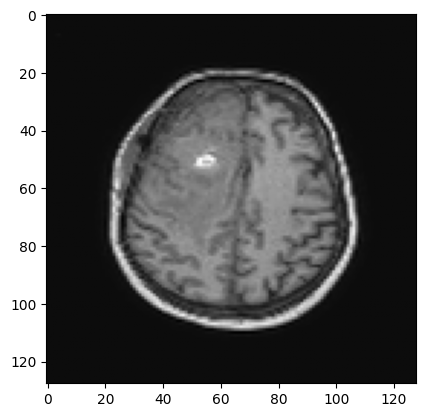

(8, 128, 128)
Plage des valeurs des images d'entrée (bruitées) : 0.0 - 1.000000041637677
torch.Size([8, 1, 128, 128])


In [26]:
# tester avec Pelvis pour un model entrainer avec des cerveau

indices=[102, 30, 135, 79, 6, 150, 109, 145]

data = np.load("images_brain_128.npy")
bigy_test=data[indices]

print(bigy_test.shape)
print("Mean:", bigy_test.mean().item())
print(f"le min et le max {bigy_test.min()} -{bigy_test.max()}")
print(bigy_test[4,32,:])
# Affichage d’une image
plt.imshow(bigy_test[4,:,:], cmap="gray")
plt.show()

images_test_normalized = list(bigy_test)

bigy_test = np.stack(images_test_normalized) #Empiler un tableau nunpy
print(bigy_test.shape)
print(f"Plage des valeurs des images d'entrée (bruitées) : {bigy_test.min()} - {bigy_test.max()}")

images_test_normalized_propre=np.array(images_test_normalized)
tensor_images_test_normalized_propre= torch.from_numpy(images_test_normalized_propre)
tensor_images_test_normalized_propre = tensor_images_test_normalized_propre.unsqueeze(1)
print(tensor_images_test_normalized_propre.shape)




F_shifted.shape: torch.Size([8, 1, 128, 128])
Plage des valeurs des images d'entrée (bruitées) : 0.0 - 1.0
<class 'torch.Tensor'>
F_shifted.shape: torch.Size([8, 1, 128, 128])


Text(0.5, 1.0, 'tensor_images_test_normalized_propre ')

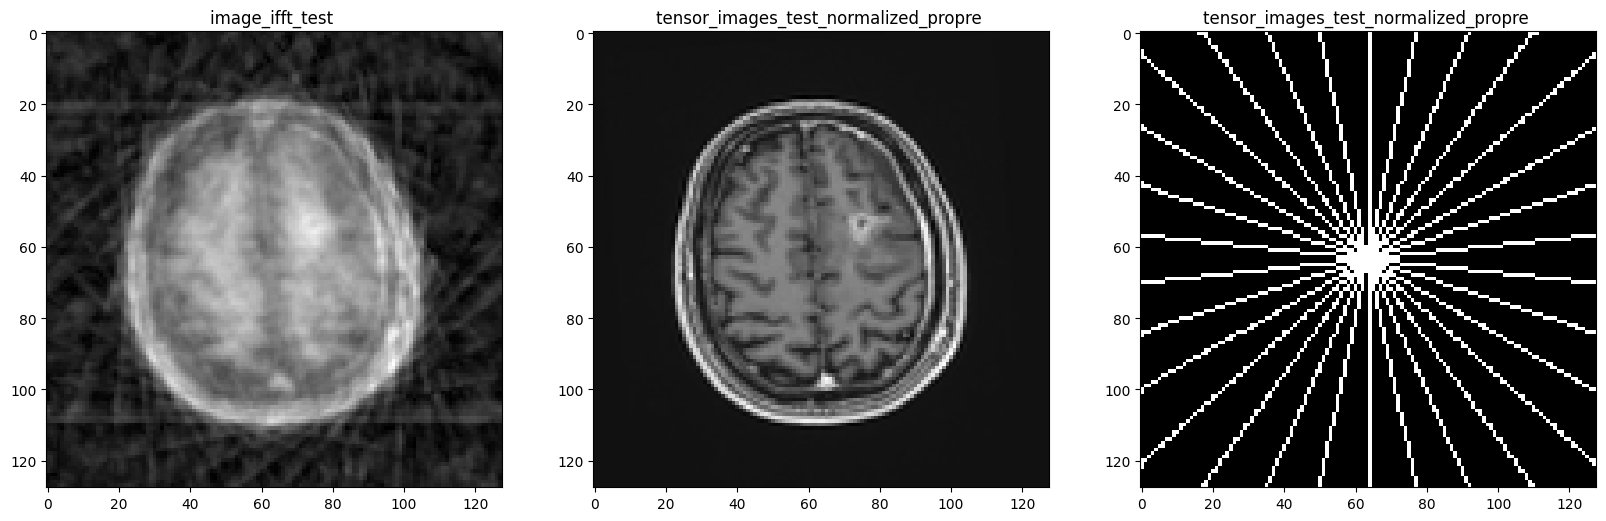

In [27]:
#Modele

import random

F_shifted_mask_test_images = []  # Liste pour stocker les F_shifted de chaque image
F_shifted_mask_test_with_images = [] 

rotation = 12

for image in(images_test_normalized):

    rot=0
    
    FT1_test = fft2(image)
    F_shifted_test = fftshift(FT1_test)

    rows, cols = F_shifted_test.shape
    crow, ccol = rows // 2, cols // 2

    # Créer un masque directionnel
    #mask1 = np.ones((rows, cols), dtype=np.float32) # Pas de masque car que des 1
    mask0_test = np.zeros((rows, cols), dtype=np.float32)
    for angle_deg in np.arange(0, 180, rotation):  
        angle_rad = np.deg2rad(angle_deg)
        dx = np.cos(angle_rad)
        dy = np.sin(angle_rad)

        for r in range(-max(rows, cols), max(rows, cols)):
            x = int(crow + r * dx)
            y = int(ccol + r * dy)
            
            if 0 <= x < rows and 0 <= y < cols:
                mask0_test[x, y] = 1

    mask1_test = np.zeros((rows, cols), dtype=np.float32)
    for x in range(0,rows,1):
        if (crow - 5 < x < crow + 5):
            mask1_test[x, :] = 1
        elif (crow - 13 < x < crow - 10):
            mask1_test[x, :] = 1
        elif (crow + 10 < x < crow + 13):
            mask1_test[x, :] = 1    
        elif (crow + 20 < x < crow + 22):
            mask1_test[x, :] = 1    
        elif (crow - 23 < x < crow - 20):
            mask1_test[x, :] = 1
        # if (crow - 7 < x < crow + 7):
        #     mask1_test[x, :] = 1
        # elif (crow - 15 < x < crow - 10):
        #     mask1_test[x, :] = 1
        # elif (crow + 10 < x < crow + 15):
        #     mask1_test[x, :] = 1    
        # elif (crow + 20 < x < crow + 25):
        #     mask1_test[x, :] = 1    
        # elif (crow - 25 < x < crow - 20):
        #     mask1_test[x, :] = 1
        # elif (crow + 30 < x < crow + 33):
        #     mask1_test[x, :] = 1    
        # elif (crow - 33 < x < crow - 30):
        #     mask1_test[x, :] = 1
        # if (crow - 15 < x < crow + 15):
        #     mask1_test[x, :] = 1   
        # elif (crow + 18 < x < crow + 25):
        #     mask1_test[x, :] = 1    
        # elif (crow - 25 < x < crow - 18):
        #     mask1_test[x, :] = 1
        # elif (crow + 30 < x < crow + 35):
        #     mask1_test[x, :] = 1    
        # elif (crow - 35 < x < crow - 30):
        #     mask1_test[x, :] = 1
        # elif (crow + 40 < x < crow + 45):
        #     mask1_test[x, :] = 1    
        # elif (crow - 45 < x < crow - 40):
        #     mask1_test[x, :] = 1
        

    # Appliquer le masque avec K_space
    F_shifted_mask_test=mask0_test #* F_shifted 
    F_shifted_mask1_test=F_shifted_test * mask0_test
    F_masked_spatial=np.abs(ifft2(ifftshift(F_shifted_mask1_test)))
    #Partie réel et imaginaire
    #real_part = np.real(F_shifted_mask)
    #imag_part = np.imag(F_shifted_mask)
    #real_part_test = F_shifted_mask_test
    #imag_part_test = F_shifted_mask_test

    #real_part1_test = np.real(F_shifted_mask1_test)
    #imag_part1_test = np.imag(F_shifted_mask1_test)
    #F_masked_complex_test = np.stack((real_part_test, imag_part_test), axis=-1)
    #F_masked_complex1_test = np.stack((real_part1_test, imag_part1_test), axis=-1)
    # magnitude_spectrum = np.abs(F_shifted_mask)
    F_shifted_mask_test_images.append(F_shifted_mask_test)
    F_shifted_mask_test_with_images.append(F_masked_spatial)



# MASQUE 2 CANAUX réel et phase
F_mask_test= np.array(F_shifted_mask_test_images)
tensor_F_mask_test = torch.from_numpy(F_mask_test)
tensor_F_mask_test = tensor_F_mask_test.unsqueeze(1)
print(f"F_shifted.shape: {tensor_F_mask_test.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_F_mask_test.min()} - {tensor_F_mask_test.max()}")


F_mask_test_image= np.array(F_shifted_mask_test_with_images)
tensor_F_mask_test_image = torch.from_numpy(F_mask_test_image)
tensor_F_mask_test_image = tensor_F_mask_test_image.unsqueeze(1)
print(type(tensor_F_mask_test_image))
print(f"F_shifted.shape: {tensor_F_mask_test_image.shape}") 
#print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_F_mask_test_image.min()} - {tensor_F_mask_test_image.max()}")


#real1_test=tensor_F_mask_test_image[0,0,:,:]
#imag1_test=tensor_F_mask_test_image[0,1,:,:]
#image_ifft_test=torch.abs(torch.fft.ifft2(torch.fft.ifftshift(tensor_F_mask_test_image[0,0,:,:])))

plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.imshow(tensor_F_mask_test_image[0,0,:,:], cmap="gray")
plt.title("image_ifft_test ")
plt.subplot(1, 3, 2)
plt.imshow(tensor_images_test_normalized_propre[0,0,:,:], cmap="gray")
plt.title("tensor_images_test_normalized_propre ")
plt.subplot(1, 3, 3)
plt.imshow(tensor_F_mask_test[0,0,:,:], cmap="gray")
plt.title("tensor_images_test_normalized_propre ")

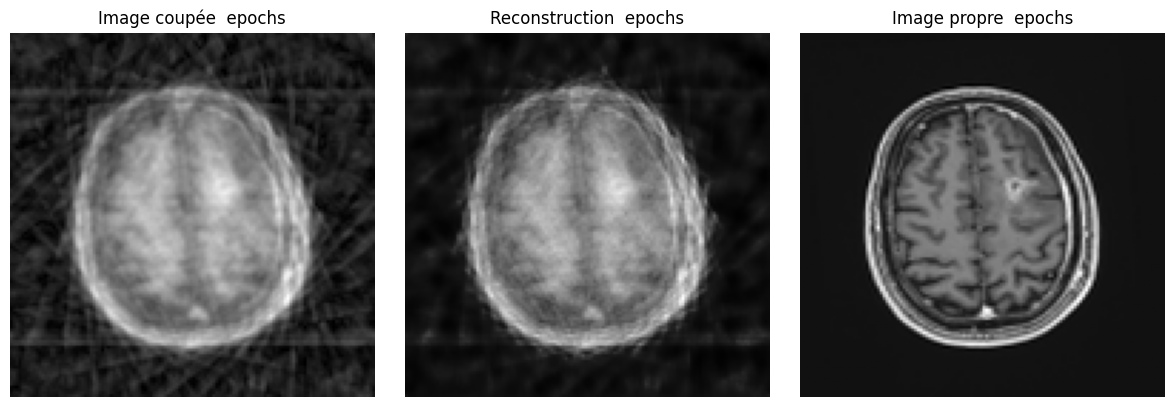

 PSNR sur ifft : 16.38 dB
 PSNR sur le modèle: 18.39 dB
 PSNR sur ifft : 16.99 dB
 PSNR sur le modèle: 18.62 dB
 PSNR sur ifft : 15.13 dB
 PSNR sur le modèle: 16.73 dB
 PSNR sur ifft : 19.13 dB
 PSNR sur le modèle: 20.79 dB
 PSNR sur ifft : 17.98 dB
 PSNR sur le modèle: 19.00 dB
 PSNR sur ifft : 15.81 dB
 PSNR sur le modèle: 16.97 dB
 PSNR sur ifft : 15.59 dB
 PSNR sur le modèle: 16.91 dB
 PSNR sur ifft : 15.44 dB
 PSNR sur le modèle: 17.28 dB
 Entrée -> 16.56 dB
 Sortie -> 18.09 dB
 ecart-type Entrée -> 1.40 dB
 ecart-type Sortie -> 1.40 dB


: 

In [ ]:
#from skimage.metrics import structural_similarity as ssim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

moyenne_PSNR_seed_entre=[]
moyenne_PSNR_seed_sortie=[]
moyenne_ecart_type_seed_entre=[]
moyenne_ecart_type_seed_sortie=[]


#for seed in dict_seed:
path_model = path_folder + f"/Unet_image_brain_radial_128_rotation0125_no_ssim.pth"
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))
model.eval()

input_imgs_liste=[]
target_imgs_liste=[]

with torch.no_grad(): #Désactive les gradients car pas de back propagation
    #input_imgs, target_imgs = next(iter(test_loader))
    # for input_imgs, target_imgs in test_loader:
    #     input_imgs = input_imgs.to(device).float()
    #     target_imgs = target_imgs.to(device).float()
    #     input_imgs_liste.append(input_imgs)
    #     target_imgs_liste.append(target_imgs)


    #     input_imgs = torch.cat(input_imgs_liste, dim=0)
    #     target_imgs = torch.cat(target_imgs_liste, dim=0)

    input_imgs = tensor_F_mask_test_image.to(device).float()
    target_imgs = tensor_images_test_normalized_propre.to(device).float()

    reconstructed = model(input_imgs)

    batch_size=input_imgs.shape[0]
    # Prendre le premier exemple du batch
    i = 0
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(input_imgs[i].squeeze().cpu(), cmap='gray')
    axs[0].set_title(f"Image coupée  epochs" )
    axs[1].imshow(reconstructed[i].squeeze().cpu(), cmap='gray')
    axs[1].set_title(f"Reconstruction  epochs")
    axs[2].imshow(target_imgs[i].squeeze().cpu(), cmap='gray')
    axs[2].set_title(f"Image propre  epochs")

    test_ifft = (input_imgs[i]- torch.min(input_imgs[i]))/(torch.max(input_imgs[i])-torch.min(input_imgs[i]))

    mse1 = torch.mean((test_ifft - target_imgs[i]) ** 2)
    psnr_value1 = 10 * torch.log10(1.0 / mse1)
    #print(f" PSNR sur l'image d'entrée : {psnr_value1:.2f} dB")   
    #print(input_imgs.min())
    #print(input_imgs.max())

    test_modele = (reconstructed[i] - torch.min(reconstructed[i]))/(torch.max(reconstructed[i])-torch.min(reconstructed[i]))

    # Calculer la MSE (Mean Squared Error)
    mse2 = torch.mean((test_modele - target_imgs[i])** 2)
    psnr_value2 = 10 * torch.log10(1.0 / mse2)
    #print(f" PSNR sur l'image de sortie du modèle: {psnr_value2:.2f} dB")
    
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    psnr_somme1=0
    psnr_somme2=0

    liste_psnr_values1 = []
    #image reconstruite
    liste_psnr_values2 = []

    liste_ssim_values1 = []
    #image reconstruite
    liste_ssim_values2 = []

    for i in range (batch_size):
        # Calculer la MSE/PSNR (Mean Squared Error)

        test_ifft = (input_imgs[i]- torch.min(input_imgs[i]))/(torch.max(input_imgs[i])-torch.min(input_imgs[i]))

        mse1 = torch.mean((target_imgs[i] - test_ifft) ** 2)
        psnr_value1 = 10 * torch.log10(1.0 **2/ mse1)
        liste_psnr_values1.append(psnr_value1)
        print(f" PSNR sur ifft : {psnr_value1:.2f} dB")   
        
        test_modele = (reconstructed[i] - torch.min(reconstructed[i]))/(torch.max(reconstructed[i])-torch.min(reconstructed[i]))

        # Calculer la MSE/PSNR (Mean Squared Error)
        mse2 = torch.mean((target_imgs[i] - test_modele)** 2)
        psnr_value2 = 10 * torch.log10(1.0**2 / mse2)
        liste_psnr_values2.append(psnr_value2)
        print(f" PSNR sur le modèle: {psnr_value2:.2f} dB")    


    
    # Conversion en tenseur pour calculs statistiques
    psnr_values_input = torch.tensor(liste_psnr_values1)
    psnr_values_output = torch.tensor(liste_psnr_values2)

    ssim_values_input = torch.tensor(liste_ssim_values1)
    ssim_values_output = torch.tensor(liste_ssim_values2)

    #Moyenne PSNR
    PNSR_entre=torch.mean(psnr_values_input)
    PSNR_sortie=torch.mean(psnr_values_output)

    #Ecart_type PSNR
    ecart_type_entre=torch.std(psnr_values_input)
    ecart_type_sortie=torch.std(psnr_values_output)


    print(f" Entrée -> {PNSR_entre:.2f} dB")    
    moyenne_PSNR_seed_entre.append(PNSR_entre)   
    print(f" Sortie -> {PSNR_sortie:.2f} dB") 
    moyenne_PSNR_seed_sortie.append(PSNR_sortie)   
    print(f" ecart-type Entrée -> {ecart_type_entre:.2f} dB") 
    moyenne_ecart_type_seed_entre.append(ecart_type_entre)     
    print(f" ecart-type Sortie -> {ecart_type_sortie:.2f} dB")
    moyenne_ecart_type_seed_sortie.append(ecart_type_sortie) 

        
    
    








In [ ]:

# Entree
moyenne_PSNR_entree=0
for m in moyenne_PSNR_seed_entre:
    moyenne_PSNR_entree+=m
    
print(f"Moyenne_PSNR_entree: {moyenne_PSNR_entree/5}")
F_moyenne_PSNR_seed_entree=torch.tensor(moyenne_PSNR_seed_entre)
ecart_type_entre_PSNR_entree=torch.std(F_moyenne_PSNR_seed_entree)
print(f"Ecart-type: {ecart_type_entre_PSNR_entree}")

# Sortie
moyenne_PSNR_sortie=0
for m in moyenne_PSNR_seed_sortie:
    #print(m)
    moyenne_PSNR_sortie+=m
    
print(f"Moyenne_PSNR_sortie: {moyenne_PSNR_sortie/5}")
F_moyenne_PSNR_seed_sortie=torch.tensor(moyenne_PSNR_seed_sortie)
ecart_type_entre_PSNR_sortie=torch.std(F_moyenne_PSNR_seed_sortie)
print(f"Ecart-type: {ecart_type_entre_PSNR_sortie}")



Moyenne_PSNR_entree: 5.211867332458496
Ecart-type: nan
Moyenne_PSNR_sortie: 4.965997219085693
Ecart-type: nan


C:\Users\rapha\AppData\Local\Temp\ipykernel_6240\897456349.py:8: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  ecart_type_entre_PSNR_entree=torch.std(F_moyenne_PSNR_seed_entree)
C:\Users\rapha\AppData\Local\Temp\ipykernel_6240\897456349.py:19: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  ecart_type_entre_PSNR_sortie=torch.std(F_moyenne_PSNR_seed_sortie)
